# Heart Rate Analysis Notebook

In [3]:
import sys
import getpass
from pathlib import Path
from datetime import date

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

import pyedflib
from pandas.compat import StringIO

import hrvanalysis
from ecgdetectors import Detectors
import heartpy as hp

### Pulling in data

In [8]:
data, _ = hp.load_exampledata(1)
df = pd.DataFrame(data).reset_index().rename(columns={0:'value','index':'time'})
df.head()

,time,value
0,0,515
1,1,514
2,2,514
3,3,512
4,4,512


Text(0, 0.5, 'electrical activity')

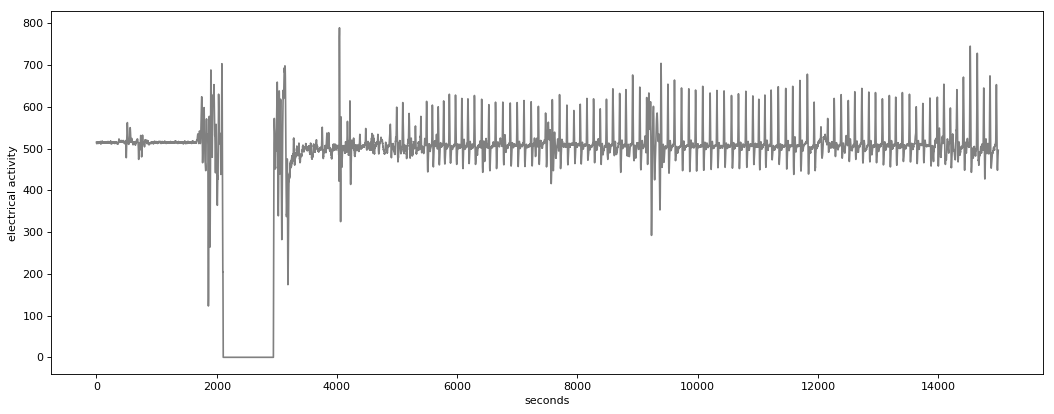

In [9]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df.value, color='grey')
plt.xlabel('seconds')
plt.ylabel('electrical activity')

### ECG Signal Processing
Peak detection and rejection -- HRV feature calculation

In [10]:
sampling_rate = 100
ecg_data, ecg_measures = hp.process(df.value, sampling_rate)

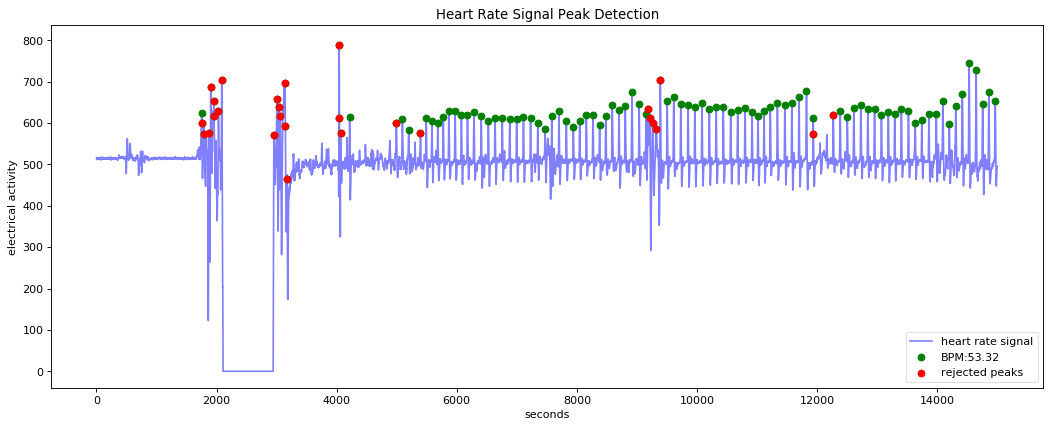

In [11]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('seconds')
plt.ylabel('electrical activity')
hp.plotter(ecg_data, ecg_measures)

### BPM over time calculation
Identifying the rolling BPM <br>
- notes:
    - `processed_data -- data that has been run through the heartpy processing step`
    - `data -- raw data that has the time stamps`

In [139]:
def calculate_bpm(processed_data, data, sampling_rate): 

    bpm = pd.DataFrame(columns=['time','bpm'])

    for i in range(0,len(processed_data['peaklist'])):
        # avoid the first index for issues
        if i != 0:
            interval = (processed_data['peaklist'][i] - processed_data['peaklist'][i-1])/sampling_rate
            current_bpm = 60*interval

            # access the time this data is taken from
            current_time = data.loc[i].time

            # only take data points that make sense -- this could be more thorough based on what the BPM looks like around the current point
            if (current_bpm > 30) and (current_bpm < 220):
                bpm.loc[i] = [current_time, current_bpm]

    bpm = bpm.reset_index().drop('index',1)
    
    return bpm

In [156]:
bpm = calculate_bpm(ecg_data, df, sampling_rate)
bpm.head()

,time,bpm
0,3.0,49.8
1,5.0,30.6
2,7.0,43.8
3,8.0,33.0
4,13.0,43.8


Text(0, 0.5, 'bpm')

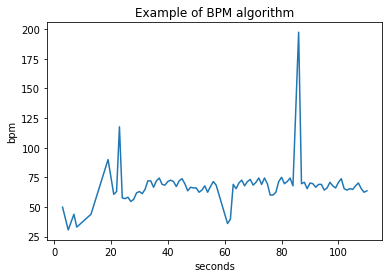

In [142]:
plt.plot(bpm.time,bpm.bpm)
plt.title('Example of BPM algorithm')
plt.xlabel('seconds')
plt.ylabel('bpm')

### ECG metric Calculation
min, max and average HR calculation

In [153]:
def calculate_hr_metrics(data):
    
    # pull current date that the algo is run
    current_date = date.today()
    
    df = pd.DataFrame(columns=['date','max_hr','min_hr','avg_hr'])
  
    df.loc[0] = [current_date,
                 data.bpm.max(),
                 data.bpm.min(), 
                 data.bpm.mean()]
    
    return df

In [155]:
hr_metrics = calculate_hr_metrics(bpm)
hr_metrics

,date,max_hr,min_hr,avg_hr
0,2020-04-11,197.4,30.6,67.447826
